In [3]:
# Loading the Dataset by Declaring Variables
import os

DATASET_PATH = "D:/Georgian/AIDI/Sem_2/AI_Project/Project/UrbanSound8K/"
AUDIO_FOLDER = os.path.join(DATASET_PATH, "audio")
METADATA_FILE = os.path.join(DATASET_PATH, "metadata/UrbanSound8K.csv")

In [5]:
import os
import librosa
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm


# Load metadata
metadata = pd.read_csv(METADATA_FILE)

def extract_features_cnn_rnn(file_path):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        
        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_mean = np.mean(mel_spec, axis=1)

        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast_mean = np.mean(contrast, axis=1)

        # Concatenate all features
        features = np.hstack([mfcc_mean, chroma_mean, mel_spec_mean, contrast_mean])

        return features
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# Extract features and save
cnn_rnn_features = []
labels = []

print("Extracting CNN/RNN features...")

for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = os.path.join(AUDIO_FOLDER, f"fold{row['fold']}/{row['slice_file_name']}")
    label = row['classID']

    features = extract_features_cnn_rnn(file_path)
    if features is not None:
        cnn_rnn_features.append(features)
        labels.append(label)

# Convert to numpy array
cnn_rnn_features = np.array(cnn_rnn_features, dtype=np.float32)
labels = np.array(labels)

# Save features
with open("cnn_rnn_features.pkl", "wb") as f:
    pickle.dump((cnn_rnn_features, labels), f)

print("CNN/RNN feature extraction complete. Saved as cnn_rnn_features.pkl")


Extracting CNN/RNN features...


  1%|          | 67/8732 [00:06<11:57, 12.08it/s]C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 41%|████      | 3554/8732 [04:38<06:51, 12.58it/s]C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8324/8732 [10:56<00:25, 15.90it/s]C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8327/8732 [10:56<00:21, 18.95it/s]C:\Users\Manoj\AppData\Local\Packa

CNN/RNN feature extraction complete. Saved as cnn_rnn_features.pkl


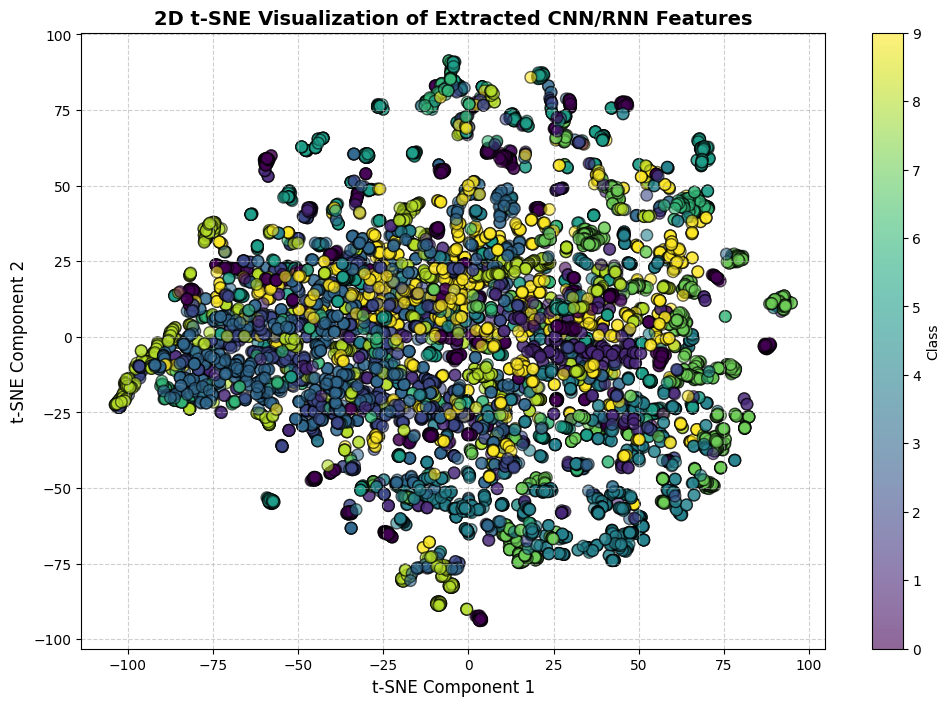

In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Load the saved features
with open("cnn_rnn_features.pkl", "rb") as f:
    cnn_rnn_features, labels = pickle.load(f)

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Use t-SNE for better visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
reduced_features = tsne.fit_transform(cnn_rnn_features)

# Define color map
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                      c=labels_encoded, cmap='viridis', s=70, alpha=0.6, edgecolors="k")

# Add colorbar with proper labels
cbar = plt.colorbar(scatter)
cbar.set_label("Class")

# Add grid and title
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("2D t-SNE Visualization of Extracted CNN/RNN Features", fontsize=14, fontweight="bold")
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)

# Show plot
plt.show()


In [8]:
import os
import librosa
import numpy as np
import pandas as pd
import pickle
import cv2
from tqdm import tqdm


# Load metadata
metadata = pd.read_csv(METADATA_FILE)

def extract_features_ast(file_path, target_size=(128, 500)):
    try:
        y, sr = librosa.load(file_path, sr=16000)  # AST model requires 16kHz audio
        
        # Convert to Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        
        # Convert to log scale (required for AST)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Resize using interpolation
        mel_spec_resized = cv2.resize(mel_spec_db, target_size, interpolation=cv2.INTER_AREA)
        
        return mel_spec_resized
    except Exception as e:
        print(f"Error extracting AST features from {file_path}: {e}")
        return None

# Extract features and save
ast_features = []
labels = []

print("Extracting AST features...")

for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = os.path.join(AUDIO_FOLDER, f"fold{row['fold']}/{row['slice_file_name']}")
    label = row['classID']

    features = extract_features_ast(file_path)
    if features is not None:
        ast_features.append(features)
        labels.append(label)

# Convert to numpy array
ast_features = np.array(ast_features, dtype=np.float32)
labels = np.array(labels)

# Save features
with open("ast_features.pkl", "wb") as f:
    pickle.dump((ast_features, labels), f)

print("AST feature extraction complete. Saved as ast_features.pkl")

Extracting AST features...


 24%|██▍       | 2121/8732 [00:54<02:31, 43.63it/s]C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1551
  warnings.warn(
C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1757
  warnings.warn(
 25%|██▌       | 2208/8732 [00:57<02:54, 37.37it/s]C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1600
  warnings.warn(
 32%|███▏      | 2825/8732 [01:12<02:32, 38.73it/s]C:\Users\Manoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2k

AST feature extraction complete. Saved as ast_features.pkl


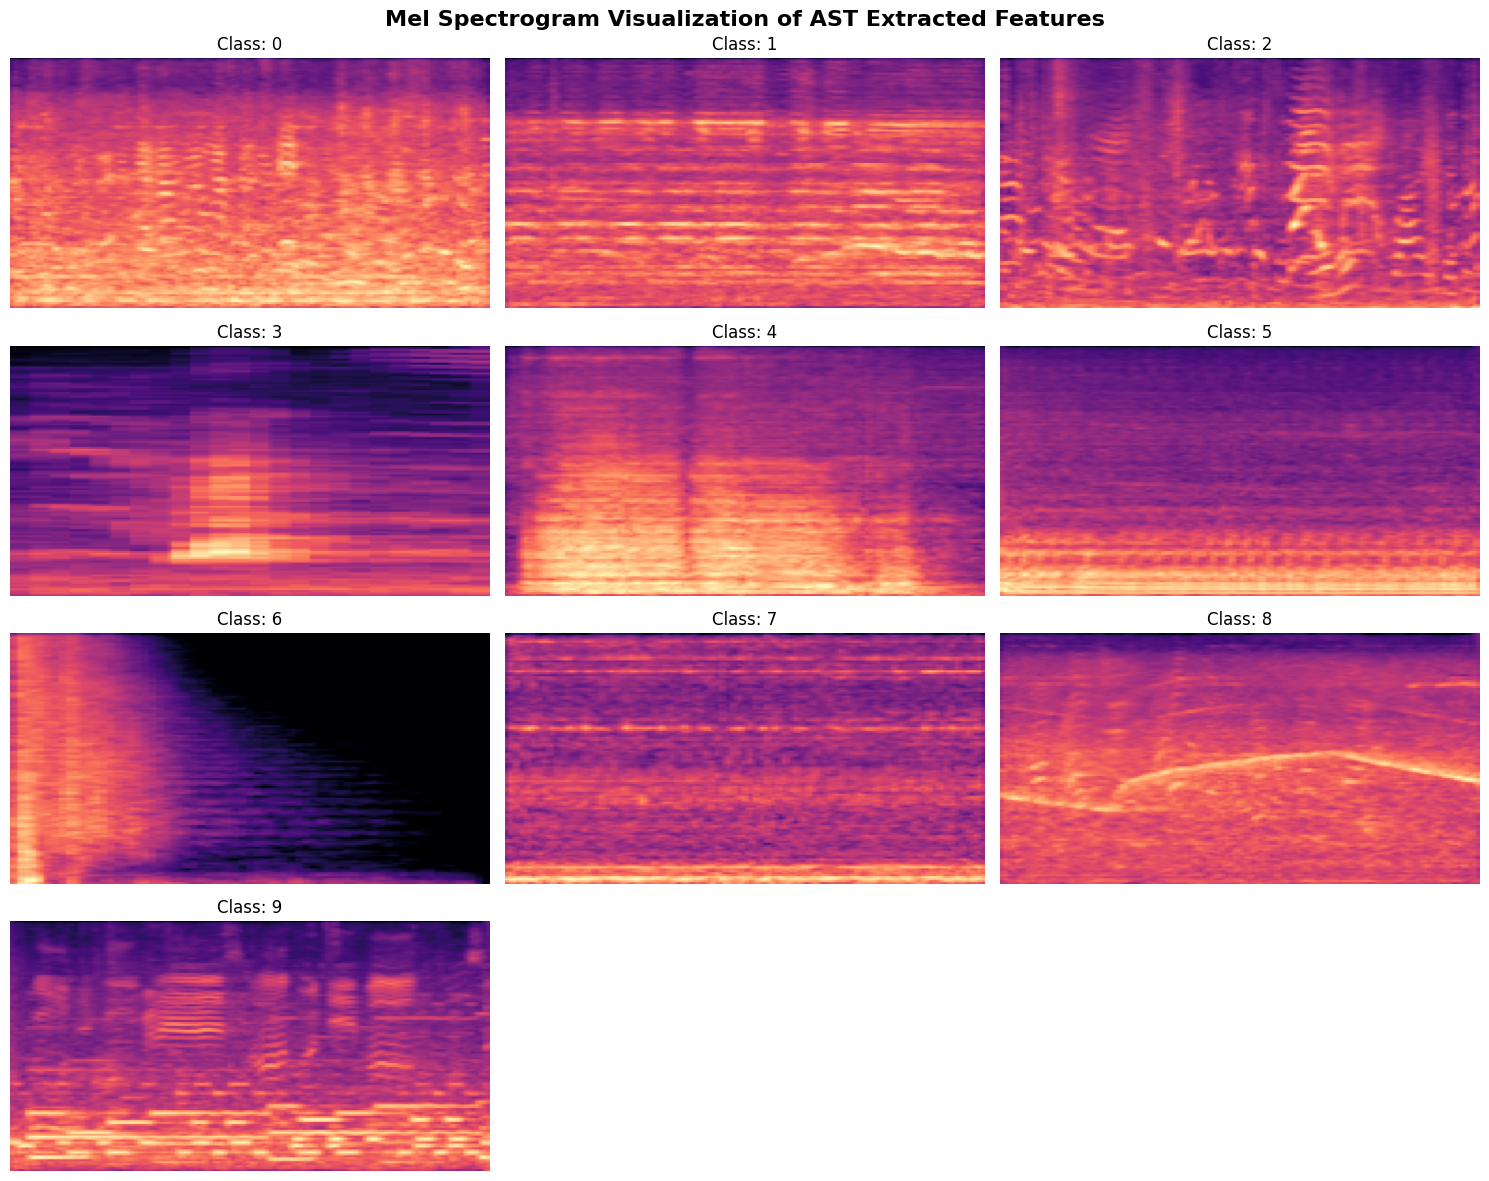

In [10]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import math

# Load AST features
with open("ast_features.pkl", "rb") as f:
    ast_features, labels = pickle.load(f)

# Convert labels to numpy array (if not already)
labels = np.array(labels)

# Get unique classes and select one sample per class
unique_classes = np.unique(labels)
num_classes = len(unique_classes)  # Total unique classes

# Ensure we don't exceed the available number of samples
selected_indices = []
for cls in unique_classes:
    indices = np.where(labels == cls)[0]
    if len(indices) > 0:
        selected_indices.append(random.choice(indices))

# Dynamically adjust the grid size
cols = 3  # Fixed number of columns
rows = math.ceil(num_classes / cols)  # Calculate required rows

# Plot the spectrograms
plt.figure(figsize=(15, rows * 3))  # Adjust figure size dynamically

for i, idx in enumerate(selected_indices):
    plt.subplot(rows, cols, i + 1)  # Adjust rows dynamically
    plt.imshow(ast_features[idx], aspect='auto', cmap='magma', origin='lower')
    plt.title(f"Class: {labels[idx]}")
    plt.axis("off")

plt.suptitle("Mel Spectrogram Visualization of AST Extracted Features", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()
